## Data Engineering Capstone Project

### Business Requirements - ETL
### 1. Functional Requirements - Load Credit Card Database (SQL)

#### Req-1.1	Data Extraction and Transformation with Python and PySpark
#### Functional Requirement 1.1
a)	For “Credit Card System,” create a Python and PySpark SQL program to read/extract the following JSON files according to the specifications found in the mapping document.
 
1. CDW_SAPP_BRANCH.JSON
2. CDW_SAPP_CREDITCARD.JSON
3. CDW_SAPP_CUSTOMER.JSON

Note: Data Engineers will be required to transform the data based on the requirements found in the Mapping Document.

Hint: [You can use  PySQL “select statement query” or simple Pyspark RDD].

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Initialize Spark session
spark = SparkSession.builder.appName("CreditCardSystemETL").getOrCreate()

# Load CDW_SAPP_BRANCH.JSON into a DataFrame
cdw_sapp_branch_source_df = spark.read.json("C:/Users/vicky/Documents/perscholars/capstone/dataset/cdw_sapp_branch.json")

# Transformation based on mapping document
cdw_sapp_branch = cdw_sapp_branch_source_df \
    .withColumn("BRANCH_CODE", col("BRANCH_CODE").cast("int")) \
    .withColumn("BRANCH_NAME", col("BRANCH_NAME").cast("varchar(64)")) \
    .withColumn("BRANCH_STREET", col("BRANCH_STREET").cast("varchar(64)")) \
    .withColumn("BRANCH_CITY", col("BRANCH_CITY").cast("varchar(64)")) \
    .withColumn("BRANCH_STATE", col("BRANCH_STATE").cast("varchar(64)")) \
    .withColumn("BRANCH_ZIP", 
                when(col("BRANCH_ZIP").isNotNull(),
                     col("BRANCH_ZIP").cast("int"))
                .otherwise(99999)) \
    .withColumn("BRANCH_PHONE", 
                concat(lit("("), substring("BRANCH_PHONE", 1, 3), lit(")"), 
                        substring("BRANCH_PHONE", 4, 3), lit("-"), 
                        substring("BRANCH_PHONE", 7, 4)).cast("varchar(64)")) \
    .withColumn("LAST_UPDATED", col("LAST_UPDATED").cast("timestamp"))


""" lit is a function that creates a literal column or expression. 
In this case, it's used to create literal strings "(" , ")", and "-". """

""" substring("BRANCH_PHONE", start, length) """


cdw_sapp_branch.printSchema()
cdw_sapp_branch.show(2)

root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: integer (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: integer (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)

+-----------+-----------+------------+-------------+------------+-----------------+----------+-------------------+
|BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|       LAST_UPDATED|
+-----------+-----------+------------+-------------+------------+-----------------+----------+-------------------+
|  Lakeville|          1|Example Bank|(123)456-5276|          MN|     Bridle Court|     55044|2018-04-18 13:51:47|
|    Huntley|          2|Example Bank|(123)461-8993|          IL|Washington Street|     60142|2018-04-18 13:51:47|
+-----------+-----------+------------+-------------+------------+-

In [2]:
# Load CDW_SAPP_CREDITCARD.JSON into a DataFrame
cdw_sapp_credit_source_df = spark.read.json("C:/Users/vicky/Documents/perscholars/capstone/dataset/cdw_sapp_credit.json")


""" To ensure that the month and day are in a two-digit format (e.g., 01 instead of 1), 
we can use the lpad function in PySpark.  
Use lpad to ensure that the MONTH and DAY columns have two digits, padding with a leading zero if needed. 
This will ensure that the resulting "TIMEID" is in the format YYYYMMDD."""



# Transformation based on the mapping document
cdw_sapp_credit_card = cdw_sapp_credit_source_df \
    .withColumn("CUST_CC_NO", col("CREDIT_CARD_NO").cast("varchar(64)")) \
    .withColumn("MONTH", lpad(col("MONTH"), 2, '0')) \
    .withColumn("DAY", lpad(col("DAY"), 2, '0')) \
    .withColumn("TIMEID", concat(col("YEAR"), col("MONTH"), col("DAY")).cast("varchar(64)")) \
    .withColumn("CUST_SSN", col("CUST_SSN").cast("int")) \
    .withColumn("BRANCH_CODE", col("BRANCH_CODE").cast("int")) \
    .withColumn("TRANSACTION_TYPE", col("TRANSACTION_TYPE").cast("varchar(64)")) \
    .withColumn("TRANSACTION_VALUE", col("TRANSACTION_VALUE").cast("double")) \
    .withColumn("TRANSACTION_ID", col("TRANSACTION_ID").cast("int")) \
    .drop("DAY", "MONTH", "YEAR", "CUST_CC_NO") #do not need to extract them as separate columns
    

cdw_sapp_credit_card.printSchema()
cdw_sapp_credit_card.show(2)

root
 |-- BRANCH_CODE: integer (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: integer (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TIMEID: string (nullable = true)

+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|  TIMEID|
+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|        114|4210653349028689|123459988|             1|       Education|             78.9|20180214|
|         35|4210653349028689|123459988|             2|   Entertainment|            14.24|20180320|
+-----------+----------------+---------+--------------+----------------+-----------------+--------+
only showing top 2 rows



In [4]:
# Load CDW_SAPP_CUSTOMER.JSON into a DataFrame
cdw_sapp_custmer_source_df = spark.read.json("C:/Users/vicky/Documents/perscholars/capstone/dataset/cdw_sapp_custmer.json")

import random

# Define Random Area Codes
random_area_codes = ['123', '456', '789']

# Function to generate a random area code
def generate_random_area_code():
    return random.choice(random_area_codes)

""" This function uses the random.choice function to randomly select an area code from the defined random_area_codes list. """

# Register the function as a UDF (User Defined Function)
spark.udf.register("random_area_code", generate_random_area_code)

""" This line registers the generate_random_area_code function as a User Defined Function (UDF) named "random_area_code" in the Spark context. 
This UDF will allow us to generate a random area code for each row in a DataFrame. """

# Transformation based on the mapping document
cdw_sapp_custmer = cdw_sapp_custmer_source_df \
    .withColumn("SSN", col("SSN").cast("int")) \
    .withColumn("FIRST_NAME", initcap(col("FIRST_NAME")).cast("varchar(64)")) \
    .withColumn("MIDDLE_NAME", lower(col("MIDDLE_NAME")).cast("varchar(64)")) \
    .withColumn("LAST_NAME", initcap(col("LAST_NAME")).cast("varchar(64)")) \
    .withColumn("CREDIT_CARD_NO", col("CREDIT_CARD_NO").cast("varchar(64)")) \
    .withColumn("FULL_STREET_ADDRESS", concat(col("APT_NO"), lit(", "), col("STREET_NAME")).cast("varchar(64)")) \
    .withColumn("CUST_CITY", col("CUST_CITY").cast("varchar(64)")) \
    .withColumn("CUST_STATE", col("CUST_STATE").cast("varchar(64)")) \
    .withColumn("CUST_COUNTRY", col("CUST_COUNTRY").cast("varchar(64)")) \
    .withColumn("CUST_ZIP", col("CUST_ZIP").cast("int")) \
    .withColumn("RANDOM_AREA_CODE", expr("random_area_code()")) \
    .withColumn("CUST_PHONE", 
                concat(lit("("), 
                       col("RANDOM_AREA_CODE"), lit(")"), 
                       substring("CUST_PHONE", 1, 3), 
                       lit("-"), 
                       substring("CUST_PHONE", 4, 4)).cast("varchar(64)")) \
    .withColumn("CUST_EMAIL", col("CUST_EMAIL").cast("varchar(64)")) \
    .withColumn("LAST_UPDATED", col("LAST_UPDATED").cast("timestamp")) \
    .drop("STREET_NAME", "APT_NO", "RANDOM_AREA_CODE")


"""  a new column "RANDOM_AREA_CODE" is added to the DataFrame using the "random_area_code" UDF.
we're using the expr function to execute the SQL expression "random_area_code()", 
which invokes a user-defined function (UDF) called "random_area_code".

expr(): This function in Spark allows you to specify an expression using SQL-like syntax or SparkSQL functions.

 """

# Print schema and show code
cdw_sapp_custmer.printSchema()
cdw_sapp_custmer.show(20)


root
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: integer (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: integer (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)

+----------------+------------+-------------+--------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|
+----------------+------------+-------------+--------------------+

In [3]:
""" This code will only have one same random area code in CUST_PHONE. """

# # Load CDW_SAPP_CUSTOMER.JSON into a DataFrame
# cdw_sapp_custmer_source_df = spark.read.json("C:/Users/vicky/Documents/perscholars/capstone/dataset/cdw_sapp_custmer.json")


# # Define Random Area Codes
# random_area_codes = ['123', '456', '789']

# # Randomly Select an Area Code
# import random
# selected_area_code = random.choice(random_area_codes)


# # Transformation based on the mapping document
# cdw_sapp_custmer = cdw_sapp_custmer_source_df \
#     .withColumn("SSN", col("SSN").cast("int")) \
#     .withColumn("FIRST_NAME", initcap(col("FIRST_NAME")).cast("varchar(64)")) \
#     .withColumn("MIDDLE_NAME", lower(col("MIDDLE_NAME")).cast("varchar(64)")) \
#     .withColumn("LAST_NAME", initcap(col("LAST_NAME")).cast("varchar(64)")) \
#     .withColumn("Credit_card_no", col("CREDIT_CARD_NO").cast("varchar(64)")) \
#     .withColumn("FULL_STREET_ADDRESS", concat(col("APT_NO"), lit(", "), col("STREET_NAME")).cast("varchar(64)")) \
#     .withColumn("CUST_CITY", col("CUST_CITY").cast("varchar(64)")) \
#     .withColumn("CUST_STATE", col("CUST_STATE").cast("varchar(64)")) \
#     .withColumn("CUST_COUNTRY", col("CUST_COUNTRY").cast("varchar(64)")) \
#     .withColumn("CUST_ZIP", col("CUST_ZIP").cast("int")) \
#     .withColumn("CUST_PHONE", 
#                 concat(lit(f"({selected_area_code})"), 
#                        substring("CUST_PHONE", 1, 3), 
#                        lit("-"), 
#                        substring("CUST_PHONE", 4, 4)).cast("varchar(64)")) \
#     .withColumn("CUST_EMAIL", col("CUST_EMAIL").cast("varchar(64)")) \
#     .withColumn("LAST_UPDATED",col("LAST_UPDATED").cast("timestamp")) \
#     .drop("STREET_NAME", "APT_NO")

# """ initcap: Translate the first letter of each word to upper case in the sentence. """

# cdw_sapp_custmer.printSchema()
# cdw_sapp_custmer.show(20)

' This code will only have one same random area code in CUST_PHONE. '

#### Req-1.2	Data loading into Database
#### Function Requirement 1.2
Once PySpark reads data from JSON files, and then utilizes Python, PySpark, and Python modules to load data into RDBMS(SQL), perform the following:
 
a)	Create a Database in SQL(MySQL), named “creditcard_capstone.” \
b)	Create a Python and Pyspark Program to load/write the “Credit Card System Data” into RDBMS(creditcard_capstone). \
Tables should be created by the following names in RDBMS: \
CDW_SAPP_BRANCH \
CDW_SAPP_CREDIT_CARD \
CDW_SAPP_CUSTOMER 


In [5]:
""" #### Create a Database in MySQL Workbench
CREATE DATABASE IF NOT EXISTS creditcard_capstone; 
"""

# Write the transformed DataFrame to a target table.
import wc_credential

cdw_sapp_branch.write.format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
    .option("user", wc_credential.mysql_username) \
    .option("password", wc_credential.mysql_password) \
    .save()

cdw_sapp_credit_card.write.format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
    .option("user",wc_credential.mysql_username) \
    .option("password", wc_credential.mysql_password) \
    .save()


cdw_sapp_custmer.write.format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER ") \
    .option("user", wc_credential.mysql_username) \
    .option("password", wc_credential.mysql_password) \
    .save()

### 2. Functional Requirements - Application Front-End

Once data is loaded into the database, we need a front-end (console) to see/display data. For that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2). 

#### Req-2.1 Transaction Details Module
#### Functional Requirements 2.1
1)    Used to display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order.


In [5]:
import mysql
import mysql.connector
import wc_credential

# Sample database connection using mysql.connector
# Replace this with your actual database connection details
conn = mysql.connector.connect(
    host='localhost',
    user= wc_credential.mysql_username,
    password=wc_credential.mysql_password,
    database='creditcard_capstone'
)

cursor = conn.cursor()

# Function to display transactions made by customers in a given zip code for a specific month and year

# use triple quotes (""") to define a multi-line string


""" The f is used to create a formatted SQL query string. 
It allows embedding Python variables (year, month, and zip_code) directly into the SQL query 
to create a dynamic query based on the input provided to the function. 
The expressions inside curly braces {} are replaced with the values of the corresponding variables.
 """


def display_transactions_by_zip(year, month, zip_code):
    query = f"""
    SELECT *
    FROM CDW_SAPP_CREDIT_CARD cc
    JOIN CDW_SAPP_BRANCH b ON cc.BRANCH_CODE = b.BRANCH_CODE
    WHERE SUBSTRING(cc.TIMEID, 1, 4) = '{year}'
      AND SUBSTRING(cc.TIMEID, 5, 2) = '{month}'
      AND b.BRANCH_ZIP = '{zip_code}'
    ORDER BY SUBSTRING(cc.TIMEID, 7, 2) DESC;
    """
    cursor.execute(query)
    transactions = cursor.fetchall()

    if not transactions:
        print(f"No transactions found for the given year, month, and zip code.")
    else:
        for transaction in transactions:
            print(transaction)


Select an option:
1. Display transactions by zip code for a given month and year.
2. Display number and total values of transactions for a given type.
3. Display total number and total values of transactions for branches in a given state.
---------------------------------------------------------------------------


ValueError: invalid literal for int() with base 10: ''

2)    Used to display the number and total values of transactions for a given type.
3)    Used to display the total number and total values of transactions for branches in a given state.

In [ ]:




# Function to display the number and total values of transactions for a given type
def display_transactions_by_type(transaction_type):
    query = f"SELECT COUNT(*), SUM(TRANSACTION_VALUE) FROM CDW_SAPP_CREDIT_CARD WHERE TRANSACTION_TYPE = '{transaction_type}';"
    cursor.execute(query)
    result = cursor.fetchone()

    if result[0] == 0:
        print(f"No transactions found for the given transaction type: {transaction_type}")
    else:
        num_transactions = result[0]
        total_value = result[1]
        total_value_str = "{:.2f}".format(total_value)  # Convert to string with 2 decimal places
        print(f"Number of {transaction_type} transactions: {num_transactions}")
        print(f"Total value of {transaction_type} transactions: {total_value_str}")








# Function to display the total number and total values of transactions for branches in a given state
def display_transactions_by_state(state):
    query = f"""
    SELECT COUNT(cc.TRANSACTION_ID), SUM(cc.TRANSACTION_VALUE)
    FROM CDW_SAPP_CREDIT_CARD cc
    JOIN CDW_SAPP_BRANCH b ON cc.BRANCH_CODE = b.BRANCH_CODE
    WHERE b.BRANCH_STATE = '{state}';
    """
    cursor.execute(query)
    result = cursor.fetchone()

    if result[0] == 0:
        print(f"No transactions found for the given state: {state}")
    else:
        num_transactions = result[0]
        total_value = result[1]
        total_value_str = "{:.2f}".format(total_value)  # Convert to string with 2 decimal places
        print(f"Total number of transactions in {state}: {num_transactions}")
        print(f"Total value of transactions in {state}: {total_value_str}")



    

if __name__ == "__main__":
    print("Select an option:")
    print("1. Display transactions by zip code for a given month and year.")
    print("2. Display number and total values of transactions for a given type.")
    print("3. Display total number and total values of transactions for branches in a given state.")
    print("---------------------------------------------------------------------------")
    

    option = int(input("Enter your choice: "))
    
    # Print the chosen option
    if option == 1:
        print("You chose: 1. Display transactions by zip code for a given month and year.")

         # Get a valid year (4 digits)
        while True:
            year = input("Enter year (4 digits): ")
            if year.isdigit() and len(year) == 4:
                break
            else:
                print("Invalid year. Please enter a 4-digit year.")

        # Get a valid month (2 digits)
        while True:
            month = input("Enter month (2 digits, e.g., 03 for March): ")
            if month.isdigit() and len(month) == 2 and 1 <= int(month) <= 12:
                # Ensure the month is in the valid range (1-12)
                break
            else:
                print("Invalid month. Please enter a 2-digit month (e.g., 03 for March).")

            # Get a valid zip code
        zip_code = input("Enter zip code: ")
        display_transactions_by_zip(year, month, zip_code)


    elif option == 2:
        print("You chose: 2. Display number and total values of transactions for a given type.")
        transaction_types = """
        Available transaction types:
        Education
        Grocery
        Bills
        Entertainment
        Healthcare
        Gas
        Test
        """
        transaction_type = input(f"Enter transaction type ({transaction_types}): ")
        display_transactions_by_type(transaction_type)

    elif option == 3:
        print("You chose: 3. Display total number and total values of transactions for branches in a given state.")
        state_instruction = "To enter a state, use its abbreviation (e.g., NY for New York)."
        
        state = input(f"{state_instruction} Enter state abbreviation: ")
        display_transactions_by_state(state)
        
    else:
        print("Invalid option.")

    # Close the database connection
    conn.close()

### Req-2.2 Customer Details
#### Functional Requirements 2.2
1) Used to check the existing account details of a customer.
2) Used to modify the existing account details of a customer.
3) Used to generate a monthly bill for a credit card number for a given month and year.
4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.


In [6]:
import mysql.connector
from mysql.connector import Error

# Establish a connection to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user= wc_credential.mysql_username,
    password=wc_credential.mysql_password,
    database='creditcard_capstone'
)

cursor = conn.cursor()


# Function to check existing account details of a customer
def check_customer_account_details(first_name, middle_name, last_name):
    query = f"""
    SELECT *
    FROM CDW_SAPP_CUSTOMER
    WHERE FIRST_NAME = '{first_name}' AND MIDDLE_NAME = '{middle_name}' AND LAST_NAME = '{last_name}';
    """

    cursor.execute(query)
    results = cursor.fetchall()
    

    if len(results) == 0:
        print("No customer found for the provided name.")
    elif len(results) == 1:
        print_customer_details(results[0])
    else:
        print("Multiple customers found for the provided name.")

        # Ask for the last four digits of SSN for further identification
        ssn_last_four = input("Enter the last four digits of SSN: ")
        matching_customers = [result for result in results if result[11][-4:] == ssn_last_four]
        
        if len(matching_customers) == 1:
            print_customer_details(matching_customers[0])


# Function to print customer details
def print_customer_details(customer):
    print("Customer Details: ")
    print(f"""Credit Card Number: {customer[0]}, City: {customer[1]}, Country: {customer[2]}, 
          Email: {customer[3]}, Phone: {customer[4]}, State: {customer[5]},
          Zip Code: {customer[6]}, First Name: {customer[7]}, Last Name: {customer[8]}, Last Updated: {customer[9]},
          Middle Name: {customer[10]}, SSN: {customer[11]}, Full Street Address: {customer[12]}""")
    


# Function to modify existing account details of a customer
def modify_customer_account_details(cust_ssn):

    # Check if the provided SSN exists
    query_check_ssn = f"SELECT * FROM CDW_SAPP_CUSTOMER WHERE SSN = {cust_ssn};"
    cursor.execute(query_check_ssn)
    result = cursor.fetchone()

    if result is None:
        print("No customer found for the provided SSN.")
        return

    while True:
        print("""Available columns to modify: 1. Credit Card Number 2. City 3. Country 4. Email 5. Phone 6. State 7. Zip Code
              8. First Name 9. Last Name 10. Last Updated 11. Middle Name 12. SSN 13. Full Street Address""")
       
        # Map the column number to the corresponding column name and description
        column_info = {
            1: ("CREDIT_CARD_NO", "credit card number"),
            2: ("CUST_CITY", "city"),
            3: ("CUST_COUNTRY", "country"),
            4: ("CUST_EMAIL", "email"),
            5: ("CUST_PHONE", "phone number (format: (XXX)-XXX-XXXX)"),
            6: ("CUST_STATE", "state (use its abbreviation e.g., NY for New York)"),
            7: ("CUST_ZIP", "zip code"),
            8: ("FIRST_NAME", "first name (use Title Case e.g., Tom for TOM)"),
            9: ("LAST_NAME", "last name (use Title Case e.g., Smith for SMITH)"),
            10: ("LAST_UPDATED", "last updated (use TIMESTAMP format e.g., 2018-04-21 09:49:02)"),
            11: ("MIDDLE_NAME", "middle name (use lower case e.g., james for JAMES)"),
            12: ("SSN", "SSN"),
            13: ("FULL_STREET_ADDRESS", "full street address (Apartment no and Street name of customer's Residence)")
        }

        column_number = int(input("Enter the number of the column you want to modify: "))
        column_info = column_info.get(column_number)

        if column_info:
            column_name, column_description = column_info
            new_value = input(f"Enter new value for {column_description}: ")

            # Construct the query to update the customer details
            set_value = f"{column_name} = '{new_value}'"
            query = f"UPDATE CDW_SAPP_CUSTOMER SET {set_value} WHERE SSN = {cust_ssn};"

            # Execute the query and commit the changes
            cursor.execute(query)
            conn.commit()

            print(f"Updated {column_description} for SSN {cust_ssn} to: {new_value}")
        else:
            print("Invalid column number.")

        confirm = input("Do you want to proceed with more changes? (yes/no): ")

        if confirm.lower() == "no":
            print("Customer account details updated successfully.")
            break

# Function to generate a monthly bill for a credit card number for a given month and year
def generate_monthly_bill(credit_card_no, year, month):
    query = f"""
    SELECT *
    FROM CDW_SAPP_CREDIT_CARD
    WHERE CREDIT_CARD_NO = '{credit_card_no}' 
        AND SUBSTRING(TIMEID, 1, 4) = '{year}'
        AND SUBSTRING(TIMEID, 5, 2) = '{month}'
    ORDER BY SUBSTRING(TIMEID, 7, 2) DESC;
    """
    cursor.execute(query)
    transactions = cursor.fetchall()

    if not transactions:
        print("No transactions found for the provided credit card number, year, and month.")
        return
    

    # Initialize total_amount
    total_amount = 0
    

    
    print("Monthly Bill:")
    print(f"Credit Card Number: {credit_card_no}")
    print(f"Year: {year}")
    print(f"Month: {month}")
    print("Transaction Details:")
    for transaction in transactions:
        print(f"Credit Card No: {transaction[1]}")
        print(f"Customer SSN: {transaction[2]}")
        print(f"Transaction ID: {transaction[3]}")
        print(f"Transaction Type: {transaction[4]}")
        print(f"Transaction Value: {transaction[5]}")
        print(f"Transaction Date: {transaction[6]}")
        print(f"Branch Code: {transaction[0]}")
        print("-----------------------------------")

        # Accumulate transaction value to total_amount
        total_amount += float(transaction[5])
    total_amount_str = "{:.2f}".format(total_amount)

    print(f"Total Amount: {total_amount_str}")


# Function to display transactions made by a customer between two dates
def display_transactions_by_customer_and_dates(cust_ssn, start_date, end_date):
    query = f"""
    SELECT *
    FROM CDW_SAPP_CREDIT_CARD
    WHERE CUST_SSN = {cust_ssn} 
        AND TIMEID BETWEEN '{start_date}' AND '{end_date}'
    ORDER BY SUBSTRING(TIMEID, 1, 4), SUBSTRING(TIMEID, 5, 2), SUBSTRING(TIMEID, 7, 2) DESC;
    """
    cursor.execute(query)
    transactions = cursor.fetchall()

    if not transactions:
        print("No transactions found for the provided Customer SSN, start_date, and end_date.")
        return
    
    print(f"Transactions for Customer SSN {cust_ssn} between {start_date} and {end_date}:")
    for transaction in transactions:
        print(f"Credit Card No: {transaction[1]}")
        print(f"Customer SSN: {transaction[2]}")
        print(f"Transaction ID: {transaction[3]}")
        print(f"Transaction Type: {transaction[4]}")
        print(f"Transaction Value: {transaction[5]}")
        print(f"Transaction Date: {transaction[6]}")
        print(f"Branch Code: {transaction[0]}")
        print("---------------------------------------------------------------------------")


In [7]:
if __name__ == "__main__":
    print("Select an option:")
    print("1. Check existing account details of a customer.")
    print("2. Modify existing account details of a customer.")
    print("3. Generate a monthly bill for a credit card number.")
    print("4. Display transactions made by a customer between two dates.")
    print("---------------------------------------------------------------------------")


    option = int(input("Enter your choice: "))


    if option == 1:
        print("You chose: 1. Check existing account details of a customer.")
        first_name = input("Enter customer first name: ")
        middle_name = input("Enter customer middle_name: ")
        last_name = input("Enter customer last name: ")
        check_customer_account_details(first_name, middle_name, last_name)
        
        
    elif option == 2:
        print("You chose: 2. Modify existing account details of a customer.")
        cust_ssn = int(input("Enter customer SSN: "))
        modify_customer_account_details(cust_ssn)
        
    elif option == 3:
        credit_card_no = input("Enter credit card number: ")
        year = input("Enter year (YYYY): ")
        month = input("Enter month (MM): ")
        generate_monthly_bill(credit_card_no, year, month)
    elif option == 4:
        cust_ssn = int(input("Enter customer SSN: "))
        start_date = input("Enter start date ((YYYYMMDD)): ")
        end_date = input("Enter end date ((YYYYMMDD)): ")
        display_transactions_by_customer_and_dates(cust_ssn, start_date, end_date)
    else:
        print("Invalid option.")

Select an option:
1. Check existing account details of a customer.
2. Modify existing account details of a customer.
3. Generate a monthly bill for a credit card number.
4. Display transactions made by a customer between two dates.
---------------------------------------------------------------------------


ValueError: invalid literal for int() with base 10: ''

## 3. Functional Requirements - Data Analysis and Visualization

After data is loaded into the database, users can make changes from the front end, and they can also view data from the front end. Now, the business analyst team wants to analyze and visualize the data.
Use Python libraries for the below requirements:


### Req - 3 Data Analysis and Visualization
#### Functional Requirements 3.1
Find and plot which transaction type has the highest transaction count.
Note: Take a screenshot of the graphs. 


In [8]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

# Establish a connection to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user= wc_credential.mysql_username,
    password=wc_credential.mysql_password,
    database='creditcard_capstone'
)

# Create a cursor
cursor = conn.cursor()

# Execute the SQL query
sql_query = "SELECT * FROM cdw_sapp_credit_card;"
cursor.execute(sql_query)

# Fetch the data into a DataFrame
cdw_sapp_credit_card_df = pd.DataFrame(cursor.fetchall(), columns=cursor.column_names)

# Close the cursor and the database connection
cursor.close()
conn.close()

cdw_sapp_credit_card_df.head()

,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID
0,114,4210653349028689,123459988,1,Education,78.90,20180214
1,35,4210653349028689,123459988,2,Entertainment,14.24,20180320
2,160,4210653349028689,123459988,3,Grocery,56.70,20180708
3,114,4210653349028689,123459988,4,Entertainment,59.73,20180419
4,93,4210653349028689,123459988,5,Gas,3.59,20181010


In [9]:
# Group by transaction type and sum the transaction values for each type
transaction_value_sum = cdw_sapp_credit_card_df.groupby('TRANSACTION_TYPE')['TRANSACTION_VALUE'].sum().reset_index()

# Rename the column to 'Total Transaction Value'
transaction_value_sum = transaction_value_sum.rename(columns={'TRANSACTION_VALUE': 'Total_Transaction_Value'})


# Sort by total transaction value in descending order
transaction_value_sum_sorted = transaction_value_sum.sort_values(by='Total_Transaction_Value', ascending=False)

# Display the sorted data
transaction_value_sum_sorted




,TRANSACTION_TYPE,Total_Transaction_Value
0,Bills,351405.28
6,Test,341310.37
5,Healthcare,340476.20
2,Entertainment,338950.10
1,Education,337980.07
4,Grocery,337051.63
3,Gas,336059.26


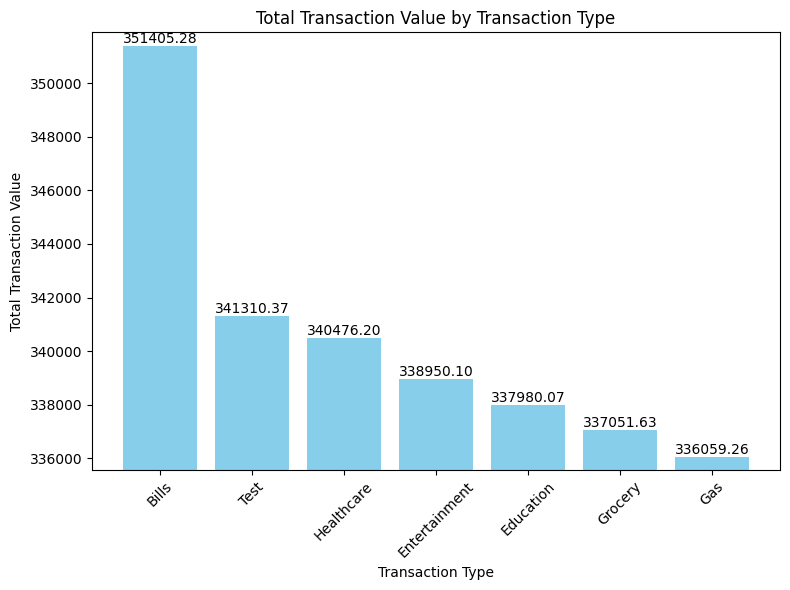

Highest transaction value: 351405.28 for transaction type Bills


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Extract transaction types and total transaction values
transaction_types = transaction_value_sum_sorted['TRANSACTION_TYPE'].tolist()
total_transaction_values = transaction_value_sum_sorted['Total_Transaction_Value'].tolist()

# Find the minimum and maximum values in the list
min_total_transaction_value = np.min(total_transaction_values)
max_total_transaction_value = np.max(total_transaction_values)

# Plot the data
plt.figure(figsize=(8, 6))
bars = plt.bar(transaction_types, total_transaction_values, color='skyblue')

# Add numbers on the bars
for bar, value in zip(bars, total_transaction_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom', color='black')

# Set y-axis limits
plt.ylim(min_total_transaction_value - 500, max_total_transaction_value + 500)

plt.xlabel('Transaction Type')
plt.ylabel('Total Transaction Value')
plt.title('Total Transaction Value by Transaction Type')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit into the figure

plt.show()


# Find the index of the maximum transaction value
index_of_max_transaction_value = np.argmax(total_transaction_values)

# Get the transaction type with the maximum transaction value
highest_transaction_type = transaction_types[index_of_max_transaction_value]
highest_transaction_value = total_transaction_values[index_of_max_transaction_value]

print(f"Highest transaction value: {highest_transaction_value:.2f} for transaction type {highest_transaction_type}")


In [15]:
# Second method: Y axis start from 0

# Plot the data
# plt.figure(figsize=(8, 6))
# bars = plt.bar(transaction_types, total_transaction_values, color='skyblue')

# # Add numbers on the bars
# for bar, value in zip(bars, total_transaction_values):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom', color='black')

# plt.xlabel('Transaction Type')
# plt.ylabel('Total Transaction Value')
# plt.title('Total Transaction Value by Transaction Type')

# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

In [16]:
# Third method: horizontal bar chart 

# import matplotlib.pyplot as plt


# # Plot the data
# plt.figure(figsize=(8, 6))
# bars = plt.barh(transaction_types, total_transaction_values, color='skyblue')

# # plt.barh(transaction_types, total_transaction_values, color='skyblue')
# plt.xlabel('Total Transaction Value')
# plt.ylabel('Transaction Type')
# plt.title('Total Transaction Value by Transaction Type')

# # Add numbers on the bars
# for bar, value in zip(bars, total_transaction_values):
#     plt.text(bar.get_width() - (bar.get_width() / 10), bar.get_y() + bar.get_height()/2, f'{value:.2f}', ha='center', va='center', color='black')


# plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
# plt.show()

# print("Transaction types with the highest transaction values:")
# print(transaction_value_sum_sorted.iloc[0])

In [17]:
# Fourth method: Pie chart

# # Plot the data as a pie chart with the new colors
# plt.figure(figsize=(8, 6))
# plt.pie(total_transaction_values, labels=transaction_types, autopct='%1.1f%%', startangle=140)
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title('Transaction Type Distribution by Total Transaction Value')
# plt.show()

#### Functional Requirements 3.2
Find and plot which state has a high number of customers.

Note: Take a screenshot of the graphs. 


In [11]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

# Establish a connection to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user= wc_credential.mysql_username,
    password=wc_credential.mysql_password,
    database='creditcard_capstone'
)

# Create a cursor
cursor = conn.cursor()

# Execute the SQL query
sql_query = "SELECT * FROM cdw_sapp_customer;"
cursor.execute(sql_query)

# Fetch the data into a DataFrame
cdw_sapp_customer_df = pd.DataFrame(cursor.fetchall(), columns=cursor.column_names)

# Close the cursor and the database connection
cursor.close()
conn.close()

cdw_sapp_customer_df.head()

,CREDIT_CARD_NO,CUST_CITY,CUST_COUNTRY,CUST_EMAIL,CUST_PHONE,CUST_STATE,CUST_ZIP,FIRST_NAME,LAST_NAME,LAST_UPDATED,MIDDLE_NAME,SSN,FULL_STREET_ADDRESS
0,4210653310061055,Natchez,United States,AHooper@example.com,(789)123-7818,MS,39120,Alec,Hooper,2018-04-21 09:49:02,wm,123456100,"656, Main Street North"
1,4210653310102868,Wethersfield,United States,EHolman@example.com,(456)123-8933,CT,6109,Etta,Holman,2018-04-21 09:49:02,brendan,123453023,"829, Redwood Drive"
2,4210653310116272,Huntley,United States,WDunham@example.com,(123)124-3018,IL,60142,Wilber,Dunham,2018-04-21 09:49:02,ezequiel,123454487,"683, 12th Street East"
3,4210653310195948,NewBerlin,United States,EHardy@example.com,(456)124-3215,WI,53151,Eugenio,Hardy,2018-04-21 09:49:02,trina,123459758,"253, Country Club Road"
4,4210653310356919,ElPaso,United States,WAyers@example.com,(123)124-2074,TX,79930,Wilfred,Ayers,2018-04-21 09:49:02,may,123454431,"301, Madison Street"


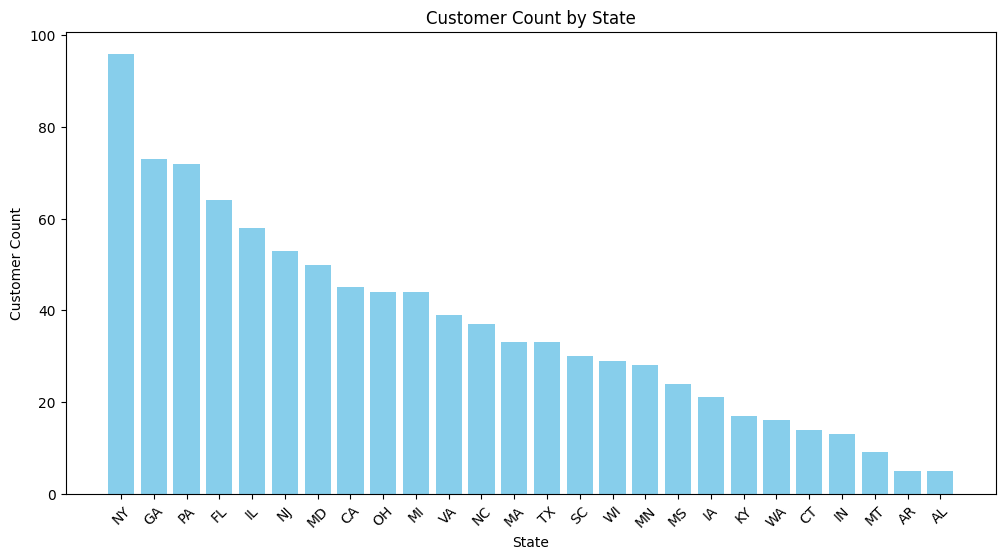

Highest customer count: 96 in state NY


In [12]:
import matplotlib.pyplot as plt

# Count the number of customers in each state using "CUST_STATE"
customer_count_by_state = cdw_sapp_customer_df['CUST_STATE'].value_counts()

# Sort by customer count in descending order
customer_count_by_state_sorted = customer_count_by_state.sort_values(ascending=False)

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(customer_count_by_state_sorted.index, customer_count_by_state_sorted.values, color='skyblue')
plt.xlabel('State')
plt.ylabel('Customer Count')
plt.title('Customer Count by State')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

# Print the highest customer count and its corresponding state
highest_customer_count_state = customer_count_by_state_sorted.idxmax()
highest_customer_count = customer_count_by_state_sorted.max()
print(f"Highest customer count: {highest_customer_count} in state {highest_customer_count_state}")

In [20]:
# Second method: cdw_sapp_custmer is the previous PySpark DataFrame, so this is the second method to use PySpark dataframe rather than pandas dataframe

# from pyspark.sql import functions as F

# # Count the number of customers in each state using "CUST_STATE" and "SSN"
# customer_count_by_state = cdw_sapp_custmer.groupby('CUST_STATE').agg(F.count('SSN').alias('CUSTOMER_COUNT')).toPandas()

# # Sort by customer count in descending order
# customer_count_by_state_sorted = customer_count_by_state.sort_values(by='CUSTOMER_COUNT', ascending=False)

# # Plot the data
# plt.figure(figsize=(12, 6))
# plt.bar(customer_count_by_state_sorted['CUST_STATE'], customer_count_by_state_sorted['CUSTOMER_COUNT'], color='skyblue')
# plt.xlabel('State')
# plt.ylabel('Customer Count')
# plt.title('Customer Count by State')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
# plt.show()

# # Print the answer (sorted customer count by state)
# print("Customer count by state (sorted in descending order):")
# print(customer_count_by_state_sorted.iloc[0])

#### Functional Requirements 3.3
Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount.
Hint (use CUST_SSN). 

Note: Take a screenshot of the graphs. 


In [13]:
# Group by customer SSN and sum the transaction values for each customer
transaction_sum_by_customer = cdw_sapp_credit_card_df.groupby('CUST_SSN') \
    .agg({'TRANSACTION_VALUE': 'sum'}) \
    .reset_index()  # Reset the index to make it a regular DataFrame

# Rename the column to 'Total_Transaction_Amount'
transaction_sum_by_customer = transaction_sum_by_customer.rename(columns={'TRANSACTION_VALUE': 'Total_Transaction_Amount'})

# Sort by total transaction amount in descending order
transaction_sum_by_customer_sorted = transaction_sum_by_customer.sort_values(by='Total_Transaction_Amount', ascending=False)

# Select the top 10 customers
top_10_customers = transaction_sum_by_customer_sorted.head(10)
print(top_10_customers)

      CUST_SSN  Total_Transaction_Amount
14   123451125                   5633.07
177  123452783                   5548.14
248  123453486                   5476.08
814  123458668                   5314.97
599  123456678                   5261.03
99   123452026                   5241.18
152  123452518                   5223.96
414  123454933                   5203.08
693  123457547                   5149.75
102  123452085                   5133.29


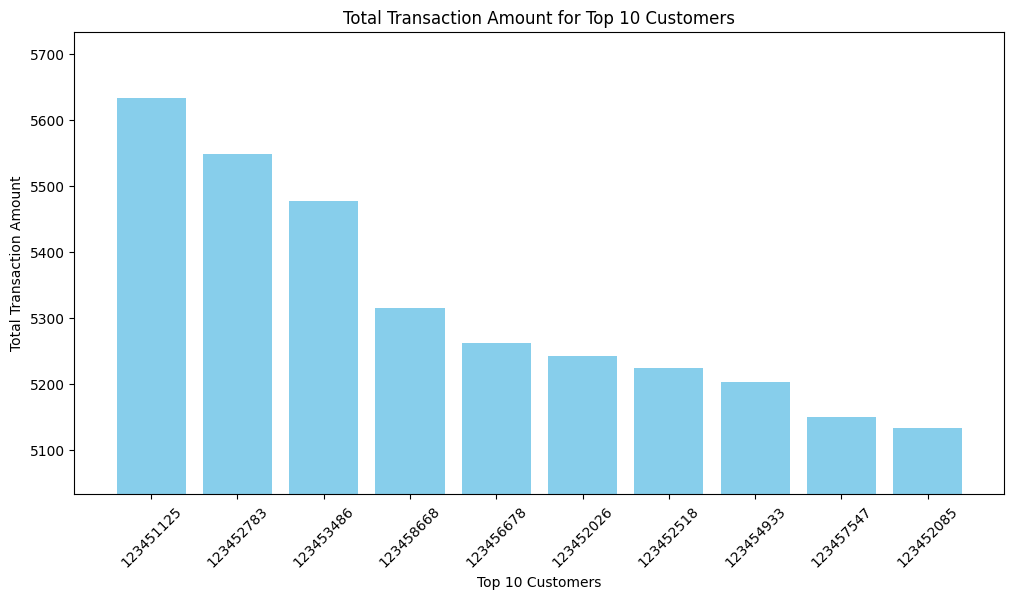

Customer with the highest transaction amount:
CUST_SSN  123451125
Total_Transaction_Amount 5633.07


In [14]:
# Plot the total transaction amount for the top 10 customers
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(top_10_customers)), top_10_customers['Total_Transaction_Amount'], color='skyblue')

# Determine the minimum and maximum transaction amounts for Y-axis limits
min_transaction_amount = top_10_customers['Total_Transaction_Amount'].min()
max_transaction_amount = top_10_customers['Total_Transaction_Amount'].max()

# Set the Y-axis limits to start from the minimum transaction amount plus 100
plt.ylim(min_transaction_amount-100, max_transaction_amount+100)

plt.xlabel('Top 10 Customers')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amount for Top 10 Customers')

# Annotate the bars with customer SSN
plt.xticks(range(len(top_10_customers)), [str(int(ssn)) for ssn in top_10_customers['CUST_SSN']], rotation=45)

plt.show()

# Determine the customer with the highest transaction amount
customer_highest_transaction = top_10_customers.iloc[0]

# Format the output
formatted_output = f"CUST_SSN  {int(customer_highest_transaction['CUST_SSN'])}\n"\
                    f"Total_Transaction_Amount {customer_highest_transaction['Total_Transaction_Amount']:.2f}"

print("Customer with the highest transaction amount:")
print(formatted_output)



In [23]:

# Second method: use PySpark Dataframe

# from pyspark.sql import functions as F
# from pyspark.sql.window import Window

# # Group by customer SSN and sum the transaction values for each customer
# transaction_sum_by_customer = cdw_sapp_credit_card.groupby('CUST_SSN') \
#     .agg(F.round(F.sum('TRANSACTION_VALUE'), 2).alias('Total_Transaction_Amount'))

# # Sort by total transaction amount in descending order
# transaction_sum_by_customer_sorted = transaction_sum_by_customer.sort(F.desc('Total_Transaction_Amount'))

# # Add a row number to identify the top 10 customers
# transaction_sum_by_customer_sorted = transaction_sum_by_customer_sorted.withColumn(
#     'row_number',
#     F.row_number().over(Window.orderBy(F.desc('Total_Transaction_Amount')))
# )

# # Select the top 10 customers
# top_10_customers = transaction_sum_by_customer_sorted.filter('row_number <= 10')

# # Show the top 10 customers
# top_10_customers.show()


In [24]:

# Third method: plot Y axis start from 0

# # Convert CUST_SSN to integer (removing decimal points)
# top_10_customers.loc[:, 'CUST_SSN'] = top_10_customers['CUST_SSN'].astype(int)

# # Plot the total transaction amount for the top 10 customers
# plt.figure(figsize=(12, 6))
# bars = plt.bar(range(len(top_10_customers)), top_10_customers['Total_Transaction_Amount'], color='skyblue')
# plt.xlabel('Top 10 Customers')
# plt.ylabel('Total Transaction Amount')
# plt.title('Total Transaction Amount for Top 10 Customers')

# # Annotate the bars with customer SSN (formatted to remove decimal point)
# for i, bar in enumerate(bars):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(top_10_customers.iloc[i]["CUST_SSN"])}', ha='center', va='bottom')

# plt.xticks(range(len(top_10_customers)), [])  # Remove x-tick labels
# plt.show()

# # Determine the customer with the highest transaction amount
# customer_highest_transaction = top_10_customers.iloc[0]

# # Format the output
# formatted_output = f"CUST_SSN  {int(customer_highest_transaction['CUST_SSN'])}\n"\
#                     f"Total_Transaction_Amount {customer_highest_transaction['Total_Transaction_Amount']:.2f}"

# print("Customer with the highest transaction amount:")
# print(formatted_output)


## 4. Functional Requirements - LOAN Application Dataset

### Req-4 Access to Loan API Endpoint
#### Functional Requirements 4.1
Create a Python program to GET (consume) data from the above API endpoint for the loan application dataset.

In [15]:
import requests
import pandas as pd

def get_loan_data(api_endpoint):
    response = requests.get(api_endpoint)
    if response.status_code == 200:
        # Data has been successfully retrieved
        return response.json()
    else:
        # Handle error cases
        print(f"Error accessing the API. Status code: {response.status_code}")
        return None

# API endpoint for loan data
api_endpoint = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"

# Call the function to get the loan data
loan_data = get_loan_data(api_endpoint)

# Convert to a DataFrame for easy display
loan_data_df = pd.DataFrame(loan_data)

# Display the first few rows
loan_data_df.head()

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y


#### Functional Requirements 4.2
Find the status code of the above API endpoint.

Hint: status code could be 200, 400, 404, 401.


In [16]:
import requests

api_endpoint = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"

def get_api_status_code(api_endpoint):
    response = requests.get(api_endpoint)
    return response.status_code

# Call the function to get the status code
status_code = get_api_status_code(api_endpoint)
print("Status code:", status_code)

Status code: 200


#### Functional Requirements 4.3
Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL). \
The table name should be CDW-SAPP_loan_application in the database.

Note: Use the “creditcard_capstone” database.


In [17]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import wc_credential

# Create a Spark session
spark = SparkSession.builder.appName("LoanApplicationLoader").getOrCreate()

# Convert the pandas DataFrame to a PySpark DataFrame
loan_data_spark = spark.createDataFrame(loan_data_df)
loan_data_spark.printSchema()
loan_data_spark.show(2)

# Write the DataFrame to the RDBMS table
try:
    loan_data_spark.write.format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("dbtable", "creditcard_capstone.CDW_SAPP_loan_application") \
        .option("user", wc_credential.mysql_username) \
        .option("password", wc_credential.mysql_password) \
        .save()
    print("Data successfully written to the RDBMS table.")
except Exception as e:
    print("An error occurred while writing data to the RDBMS table:", str(e))


root
 |-- Application_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Application_Status: string (nullable = true)

+--------------+------+-------+----------+---------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+---------+-------------+--------------+-------------+------+------------------+
|      LP001002|  Male|     No|         0| Graduate|           No|             1|        Urban|medium|                 Y|
|      LP001003|  Male|    Yes|         1| Graduate|           No|            

## 5. Functional Requirements - Data Analysis and Visualization for LOAN Application
After the data is loaded into the database, the business analyst team wants to analyze and visualize the data.\
Use Python libraries for the below requirements:

### Req-5 Data Analysis and Visualization
#### Functional Requirements 5.1
Find and plot the percentage of applications approved for self-employed applicants.
Note: Take a screenshot of the graph. 


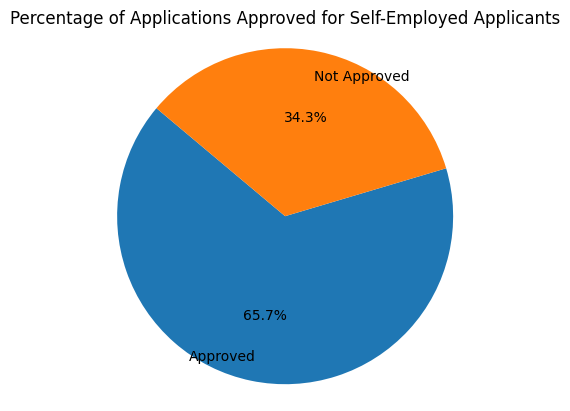

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the data for self-employed applicants
self_employed_approved = loan_data_spark.filter((loan_data_spark['Self_Employed'] == 'Yes') & (loan_data_spark['Application_Status'] == 'Y'))

# Calculate the percentage of applications approved for self-employed applicants
total_self_employed = loan_data_spark.filter(loan_data_spark['Self_Employed'] == 'Yes').count()
percentage_approved = (self_employed_approved.count() / total_self_employed) * 100

# Plot the percentage
labels = ['Approved', 'Not Approved']
sizes = [percentage_approved, 100 - percentage_approved]

# Adjust label distance for 'Not Approved'
label_distance = 0.1

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, labeldistance=0.95 - label_distance)
plt.title('Percentage of Applications Approved for Self-Employed Applicants')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show plot or save as an image
plt.show()


In [30]:
# # Second method to achieve this, use pandas not PySpark
# import pandas as pd
# import matplotlib.pyplot as plt


# # Filter the data for self-employed applicants
# self_employed_df = loan_data_df[loan_data_df['Self_Employed'] == 'Yes']

# # Calculate the percentage of applications approved for self-employed applicants
# total_self_employed = len(self_employed_df)
# approved_self_employed = len(self_employed_df[self_employed_df['Application_Status'] == 'Y'])
# percentage_approved = (approved_self_employed / total_self_employed) * 100

# # Plot the percentage
# labels = ['Approved', 'Not Approved']
# sizes = [percentage_approved, 100 - percentage_approved]
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.title('Percentage of Applications Approved for Self-Employed Applicants')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# # Show plot or save as an image
# plt.show()


#### Functional Requirements 5.2
Find the percentage of rejection for married male applicants.
Note: Take a screenshot of the graph.

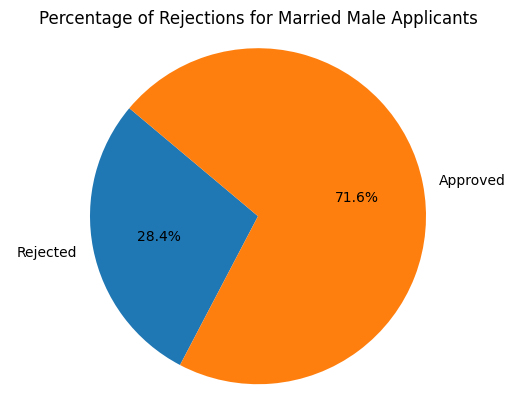

In [19]:
# Filter the data for married male applicants
married_male_rejected = loan_data_spark.filter((loan_data_spark['Married'] == 'Yes') & (loan_data_spark['Gender'] == 'Male') & (loan_data_spark['Application_Status'] == 'N'))

# Calculate the percentage of rejections for married male applicants
total_married_male = loan_data_spark.filter((loan_data_spark['Married'] == 'Yes') & (loan_data_spark['Gender'] == 'Male')).count()
percentage_rejected = (married_male_rejected.count() / total_married_male) * 100

# Plot the percentage
labels = ['Rejected', 'Approved']
sizes = [percentage_rejected, 100 - percentage_rejected]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Rejections for Married Male Applicants')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show plot or save as an image
plt.show()


In [33]:
# # Second method to achieve this, use pandas not PySpark

# import matplotlib.pyplot as plt
# import pandas as pd

# # Filter the data for married male applicants
# married_male_rejected = loan_data_df[(loan_data_df['Married'] == 'Yes') & (loan_data_df['Gender'] == 'Male') & (loan_data_df['Application_Status'] == 'N')]

# # Calculate the percentage of rejections for married male applicants
# total_married_male = len(loan_data_df[(loan_data_df['Married'] == 'Yes') & (loan_data_df['Gender'] == 'Male')])
# percentage_rejected = (len(married_male_rejected) / total_married_male) * 100

# # Plot the percentage
# labels = ['Rejected', 'Approved']
# sizes = [percentage_rejected, 100 - percentage_rejected]

# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.title('Percentage of Rejections for Married Male Applicants')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# # Show plot or save as an image
# plt.show()


#### Functional Requirements 5.3
Find and plot the top three months with the largest volume of transaction data.
Note: Take a screenshot of the graph. 


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract year and month from the 'TIMEID' column
cdw_sapp_credit_card_df['Transaction_Year'] = cdw_sapp_credit_card_df['TIMEID'].str[:4]
cdw_sapp_credit_card_df['Transaction_Month'] = cdw_sapp_credit_card_df['TIMEID'].str[4:6]

# Group by year and month and sum the transaction values to get the transaction volume
transaction_volume_by_month = cdw_sapp_credit_card_df.groupby(['Transaction_Year', 'Transaction_Month'])['TRANSACTION_VALUE'].sum()

# Sort the transaction volume in descending order and select the top three
top_three_months = transaction_volume_by_month.sort_values(ascending=False).head(3)
top_three_months

Transaction_Year  Transaction_Month
2018              10                   202583.89
                  05                   201310.26
                  12                   201251.08
Name: TRANSACTION_VALUE, dtype: float64

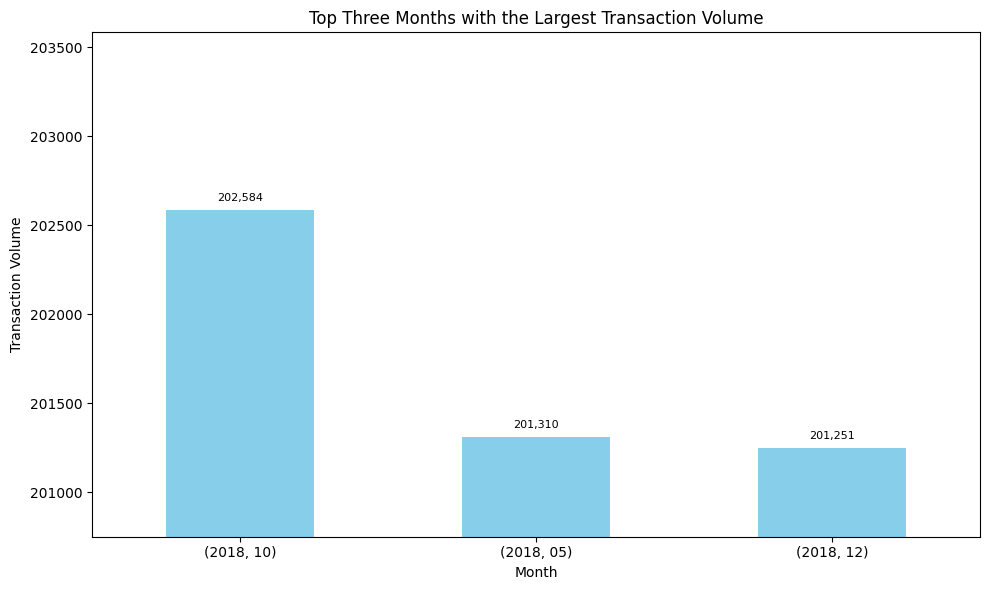

In [21]:
plt.figure(figsize=(10, 6))
ax = top_three_months.plot(kind='bar', color='skyblue')

# Set Y-axis limits to start from a value slightly lower than the minimum transaction volume
plt.ylim(top_three_months.min() - 500, top_three_months.max() + 1000)

plt.xlabel('Month')
plt.ylabel('Transaction Volume')
plt.title('Top Three Months with the Largest Transaction Volume')


# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points')
    
    
plt.xticks(rotation=0)  # Remove rotation for month labels
plt.tight_layout()

# Show plot or save as an image
plt.show()


In [45]:
# # Second method: Y axis starts from 0

# # Plot the top three months with the largest transaction volume
# plt.figure(figsize=(10, 6))
# top_three_months.plot(kind='bar', color='skyblue')
# plt.xlabel('Month')
# plt.ylabel('Transaction Volume')
# plt.title('Top Three Months with the Largest Transaction Volume')
# plt.xticks(rotation=0)  # Remove rotation for month labels
# plt.tight_layout()

# # Show plot or save as an image
# plt.show()

#### Functional Requirements 5.4
Find and plot which branch processed the highest total dollar value of healthcare transactions.
Note: Take a screenshot of the graph. 


In [22]:
# Filter healthcare transactions
healthcare_transactions = cdw_sapp_credit_card_df[cdw_sapp_credit_card_df['TRANSACTION_TYPE'] == 'Healthcare']
len(healthcare_transactions)


6723

In [23]:
# Group by branch and sum the transaction values for healthcare transactions
healthcare_by_branch = healthcare_transactions.groupby('BRANCH_CODE')['TRANSACTION_VALUE'].sum()
len(healthcare_by_branch)

114

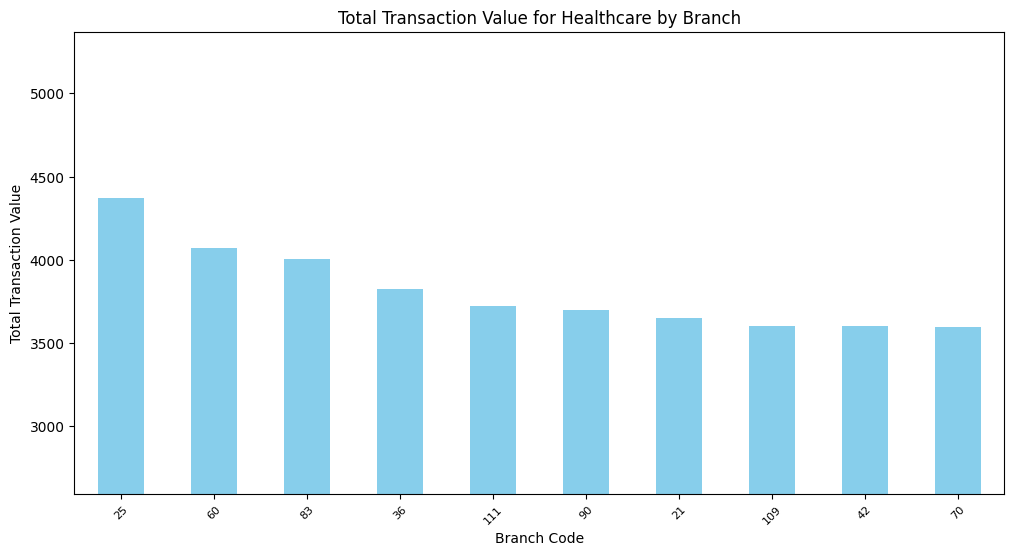

Branch with the highest healthcare transaction value: 25
Total transaction value for the highest branch: 4370.18


In [24]:
# Sort the DataFrame by transaction value in descending order and limit to top 10 branch
sorted_healthcare_by_branch = healthcare_by_branch.sort_values(ascending=False)
sorted_healthcare_by_branch = sorted_healthcare_by_branch.head(10)

# Plot all transaction values using a bar plot
plt.figure(figsize=(12, 6))
sorted_healthcare_by_branch.plot(kind='bar', color='skyblue')

# Set Y-axis limits to start from a value slightly lower than the minimum transaction value
plt.ylim(sorted_healthcare_by_branch.min() - 1000, sorted_healthcare_by_branch.max() + 1000)


plt.xlabel('Branch Code')
plt.ylabel('Total Transaction Value')
plt.title('Total Transaction Value for Healthcare by Branch')
plt.xticks(rotation=45, fontsize=8)  # Rotate x-axis labels for better visibility and adjust fontsize

# Find the branch with the highest total healthcare transaction value
highest_value_branch = sorted_healthcare_by_branch.idxmax()
highest_value = sorted_healthcare_by_branch.max()

# Show plot or save as an image
plt.show()

# Find the branch with the highest total healthcare transaction value
highest_value_branch = healthcare_by_branch.idxmax()
highest_value = healthcare_by_branch.max()

print("Branch with the highest healthcare transaction value:", highest_value_branch)
print("Total transaction value for the highest branch:", highest_value)

In [60]:
# # Second method: plot all branch and annotate the highest one in the plot
# # Plot all transaction values
# plt.figure(figsize=(12, 6))
# healthcare_by_branch.plot(kind='bar', color='skyblue')
# plt.xlabel('Branch Code')
# plt.ylabel('Total Transaction Value')
# plt.title('Total Transaction Value for Healthcare by Branch')
# plt.xticks(rotation=45,fontsize=6)  # Rotate x-axis labels for better visibility


# # Annotate the highest value and branch
# highest_value_branch = healthcare_by_branch.idxmax()
# highest_value = healthcare_by_branch.max()
# plt.annotate(f'Highest Value: {highest_value:.2f}\nBranch: {highest_value_branch}',
#              xy=(healthcare_by_branch.index.get_loc(highest_value_branch), highest_value),
#              xycoords='data', xytext=(50, 30), textcoords='offset points',
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


# plt.tight_layout()



# # Show plot or save as an image
# plt.show()

# # Find the branch with the highest total healthcare transaction value
# highest_value_branch = healthcare_by_branch.idxmax()
# highest_value = healthcare_by_branch.max()

# print("Branch with the highest healthcare transaction value:", highest_value_branch)
# print("Total transaction value for the highest branch:", highest_value)